In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from tqdm import tqdm

In [2]:
# Cargar datos con manejo de tipos para mejor performance
path_file = r"C:\Users\AndrésL\Documents\OCDS2025\subastas_inversas\bids_nombre_parties_ruc.csv"
df = pd.read_csv(path_file, encoding='utf-8', dtype={'ocid': 'category', 'amount': 'float64'})
df = df[df['amount'] != 0].copy()

C:\Users\AndrésL\AppData\Local\Temp\ipykernel_19052\251778367.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_file, encoding='utf-8', dtype={'ocid': 'category', 'amount': 'float64'})


In [ ]:
# Función optimizada de winsorización
def winsorize_group(group):
    # Calcular cuartiles más robustos (10-90 percentil)
    lower = group['amount'].quantile(0.10)
    upper = group['amount'].quantile(0.90)
    
    # Winsorizar solo si hay variabilidad suficiente
    if (upper - lower) > 0:  # Evitar grupos con mismo valor
        group['amount'] = np.clip(group['amount'], lower, upper)
    return group

# Configurar barra de progreso
tqdm.pandas(desc="Winsorizando por subasta")

# Aplicar con optimización de memoria
df = df.groupby('ocid', group_keys=False, sort=False).progress_apply(winsorize_group)

C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\544429693.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_file, encoding='utf-8', dtype={'ocid': 'category', 'amount': 'float64'})
C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\544429693.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('ocid', group_keys=False, sort=False).progress_apply(winsorize_group)
Winsorizando por subasta: 100%|██████████| 197230/197230 [05:23<00:00, 610.06it/s]


In [87]:
# Initialize results list to store metrics for each ocid
results = []

# Loop through each unique ocid
for ocid in tqdm(df['ocid'].unique(), desc="Calculating metrics"):
    bids = df[(df['ocid'] == ocid)]['amount'].dropna()
    n_t = len(bids)
    
    # Initialize dictionary to store metrics for this ocid
    metrics = {'ocid': ocid}
    
    # 1. Standard deviation and coefficient of variation
    std_dev = bids.std(ddof=1) if n_t > 1 else np.nan
    mean = bids.mean() if n_t > 0 else np.nan
    cvt = std_dev / mean if mean != 0 else float('inf')
    metrics['std_dev'] = std_dev
    metrics['mean'] = mean
    metrics['cvt'] = cvt
    
    # 2. Kurtosis, using Fisher's definition, a higher kurtosis indicates less differences between bids, thus, more likelihood for collusion
    k = kurtosis(bids, fisher=True, bias=False) if n_t >= 4 else np.nan
    metrics['kurtosis'] = k
    
    # 3. Spread
    max_bid = bids.max() if n_t > 0 else np.nan
    min_bid = bids.min() if n_t > 0 else np.nan
    spdt = (max_bid - min_bid) / min_bid if min_bid != 0 and n_t > 0 else float('inf')
    metrics['spread'] = spdt
    
    # 4. Diffp and related metrics
    sorted_bids = np.sort(bids.values)
    if n_t >= 2:
        b1t = sorted_bids[0]
        b2t = sorted_bids[1]
        diffp = (b2t - b1t) / b1t if b1t != 0 else float('inf')
        dt = b2t - b1t
        std_losing_bids = np.std(sorted_bids[2:], ddof=1) if n_t > 2 else np.nan
        rdt = dt / std_losing_bids if std_losing_bids != 0 else float('inf')
    else:
        diffp = np.nan
        dt = np.nan
        std_losing_bids = np.nan
        rdt = np.nan
    metrics['diffp'] = diffp
    metrics['dt'] = dt
    metrics['std_losing_bids'] = std_losing_bids
    metrics['rdt'] = rdt
    
    # 5. RDNOR
    if n_t >= 2:
        numerator = b2t - b1t
        sum_adjacent_diffs = sum(sorted_bids[i + 1] - sorted_bids[i] for i in range(n_t - 1))
        denominator = sum_adjacent_diffs / (n_t - 1) if n_t > 1 else np.nan
        rdnor = numerator / denominator if denominator != 0 else float('inf')
    else:
        rdnor = np.nan
    metrics['rdnor'] = rdnor
    
    # 6. Skewness
    if n_t >= 3:
        std = np.std(bids, ddof=1)
        if std == 0:
            skew = float('inf')
        else:
            standardized_bids = [(b - mean) / std for b in bids]
            skew = (n_t / ((n_t - 1) * (n_t - 2))) * sum(x ** 3 for x in standardized_bids)
    else:
        skew = np.nan
    metrics['skew'] = skew
    
    # 7. Kolmogorov-Smirnov statistic

    # Finally, we verify whether bid rigging (or competition) transforms the distribution
# of the bids into a less uniform distribution. More concisely, we again suspect that the
# higher difference between the first and the second-lowest bid influences the
# asymmetry, and thus a cartel leads to a less uniform distribution. Therefore, we
# consider the nonparametric Kolmogorov–Smirnov statistic (KS):
# D_{t}^{+} = \max_{i}(x_{it} - \frac{i_{t}}{n_{t}+1}), D_{t}^{-} = \max_{i}(\frac{i_{t}}{n_{t}+1} - x_{it}), KS_{t} = \max(D_{t}^{+}, D_{t}^{-})
# where nt is the number of bids in a tender, it the rank of a bid and xit the standardized
# bid for the i
# th rank in tender t. The standardized bids xit are the bids bit divided by the
# standard deviation of bids in tender t to facilitate the comparison of tenders with
# different contract values. We suspect that the KS-statistic should generally differ
# across cartels and competitive periods.
    if n_t >= 2:
        standardized_bids = sorted_bids / np.std(sorted_bids, ddof=1)
        d_plus = np.max([(standardized_bids[i] - (i + 1) / (n_t + 1)) for i in range(n_t)])
        d_minus = np.max([((i + 1) / (n_t + 1) - standardized_bids[i]) for i in range(n_t)])
        ks_statistic = max(d_plus, d_minus)
    else:
        ks_statistic = np.nan
    metrics['ks_statistic'] = ks_statistic
    
    # Append metrics to results
    results.append(metrics)

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display the results
results_df

C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\1745403942.py:86: RuntimeWarning: divide by zero encountered in divide
  standardized_bids = sorted_bids / np.std(sorted_bids, ddof=1)
C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\1745403942.py:21: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  k = kurtosis(bids, fisher=True, bias=False) if n_t >= 4 else np.nan
Calculating metrics: 100%|██████████| 197230/197230 [08:23<00:00, 391.55it/s]


,ocid,std_dev,mean,cvt,kurtosis,spread,diffp,dt,std_losing_bids,rdt,rdnor,skew,ks_statistic
0,ocds-5wno2w-002-CGDS-SIE-2015-591897,948.235500,15499.692308,0.061178,-1.311308,0.184255,0.000000,0.000,784.800334,0.000000,0.000000,-0.187534,16.815399
1,ocds-5wno2w-006-CGDS-SIE-2015-591897,543.058008,18634.000000,0.029143,NaN,0.042082,0.042082,768.000,NaN,NaN,1.000000,NaN,34.353533
2,ocds-5wno2w-007-SIE-GADMCH-2015-2479,774.083936,26864.600000,0.028814,NaN,0.041597,0.041597,1094.720,NaN,NaN,1.000000,NaN,34.745462
3,ocds-5wno2w-01D01-GUAR-2015-2-531336,1040.334798,19952.090909,0.052142,-2.150607,0.123542,0.000000,0.000,930.676785,0.000000,0.000000,-0.022728,19.599592
4,ocds-5wno2w-01D01-MP-SIE-2015-14-531336,788.610737,38802.960000,0.020323,NaN,0.029161,0.029161,1115.264,NaN,NaN,1.000000,NaN,49.244640
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197225,ocds-5wno2w-SIE-HEEE-2025-007-52558,861.466061,30368.029167,0.028368,-3.331993,0.053961,0.000440,13.000,784.261784,0.016576,0.040733,0.000220,35.584610
197226,ocds-5wno2w-SIE-HEP-2025-00004-889479,1027.985677,20184.359250,0.050930,-1.073625,0.114276,0.058557,1102.787,0.059397,18566.384903,1.537256,-0.895980,19.813378
197227,ocds-5wno2w-SIE-HGJD-2025-003-15643,564.967004,18707.225000,0.030200,NaN,0.043642,0.043642,798.984,NaN,NaN,1.000000,NaN,33.152507
197228,ocds-5wno2w-SIE-HGJD-2025-004-15643,1394.162997,12327.329294,0.113095,-0.898222,0.357014,0.000000,0.000,1149.300680,0.000000,0.000000,-0.909235,8.925435


In [88]:
results_df.to_excel('subasta_metrics.xlsx', index=False)

In [3]:
path_file_2 = r"C:\Users\AndrésL\Documents\OCDS2025\subasta_metrics.xlsx"

results_df = pd.read_excel(path_file_2)

In [5]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Function to compute screens for a subgroup (adapted from your code, adding RDALT as in paper)
def compute_screens(subgroup_bids):
    subgroup_bids = np.array(subgroup_bids)
    n = len(subgroup_bids)
    metrics = {}
    
    # CV
    std = np.std(subgroup_bids, ddof=1) if n > 1 else np.nan
    mean = np.mean(subgroup_bids) if n > 0 else np.nan
    cv = std / mean if mean != 0 else np.inf
    metrics['CV'] = cv
    
    # Kurtosis (requires n>=4)
    metrics['KURTO'] = kurtosis(subgroup_bids, fisher=True, bias=False) if n >= 4 else np.nan
    
    # Spread
    max_b = np.max(subgroup_bids) if n > 0 else np.nan
    min_b = np.min(subgroup_bids) if n > 0 else np.nan
    spd = (max_b - min_b) / min_b if min_b != 0 else np.inf
    metrics['SPD'] = spd
    
    # DIFFP, RD, RDNOR, RDALT
    sorted_b = np.sort(subgroup_bids)
    if n >= 2:
        b1 = sorted_b[0]
        b2 = sorted_b[1]
        d = b2 - b1
        metrics['DIFFP'] = (b2 - b1) / b1 if b1 != 0 else np.inf
        std_losing = np.std(sorted_b[1:], ddof=1) if n > 2 else np.nan
        metrics['RD'] = d / std_losing if std_losing != 0 and n > 2 else np.inf
        
        # RDNOR
        sum_adj = np.sum(np.diff(sorted_b))
        den = sum_adj / (n - 1) if n > 1 else np.nan
        metrics['RDNOR'] = d / den if den != 0 else np.inf
        
        # RDALT (using losing bids only)
        if n >= 3:
            sum_adj_losing = np.sum(np.diff(sorted_b[1:]))
            den_alt = sum_adj_losing / (n - 2) if n > 2 else np.nan
            metrics['RDALT'] = d / den_alt if den_alt != 0 else np.inf
        else:
            metrics['RDALT'] = np.nan
    else:
        metrics['DIFFP'] = metrics['RD'] = metrics['RDNOR'] = metrics['RDALT'] = np.nan
    
    # Skewness
    metrics['SKEW'] = skew(subgroup_bids, bias=False) if n >= 3 else np.nan
    
    # KS
    if n >= 2:
        std_sub = np.std(subgroup_bids, ddof=1) if np.std(subgroup_bids, ddof=1) != 0 else 1  # Avoid div/0
        std_bids = np.sort(subgroup_bids / std_sub)
        ranks = np.arange(1, n+1)
        d_plus = np.max(std_bids - ranks / (n + 1))
        d_minus = np.max(ranks / (n + 1) - std_bids)
        metrics['KS'] = max(d_plus, d_minus)
    else:
        metrics['KS'] = np.nan
    
    return metrics

# Compute summary screens
summary_results = []
for ocid in df['ocid'].unique():
    bids = df[df['ocid'] == ocid]['amount'].dropna().values
    n_t = len(bids)
    if n_t < 4:
        continue  # Skip if can't form subgroups of 4
    
    summary_metrics = {'ocid': ocid}
    
    # Subgroups of 3
    subgroups_3 = list(combinations(bids, 3))
    if subgroups_3:
        screens_3 = [compute_screens(sub) for sub in subgroups_3]
        df_screens_3 = pd.DataFrame(screens_3)
        for screen in df_screens_3.columns:
            vals = df_screens_3[screen].replace([np.inf, -np.inf], np.nan).dropna()
            if not vals.empty:
                summary_metrics[f'MEAN3{screen}'] = vals.mean()
                summary_metrics[f'MEDIAN3{screen}'] = vals.median()
                summary_metrics[f'MIN3{screen}'] = vals.min()
                summary_metrics[f'MAX3{screen}'] = vals.max()
    
    # Subgroups of 4
    subgroups_4 = list(combinations(bids, 4))
    if subgroups_4:
        screens_4 = [compute_screens(sub) for sub in subgroups_4]
        df_screens_4 = pd.DataFrame(screens_4)
        for screen in df_screens_4.columns:
            vals = df_screens_4[screen].replace([np.inf, -np.inf], np.nan).dropna()
            if not vals.empty:
                summary_metrics[f'MEAN4{screen}'] = vals.mean()
                summary_metrics[f'MEDIAN4{screen}'] = vals.median()
                summary_metrics[f'MIN4{screen}'] = vals.min()
                summary_metrics[f'MAX4{screen}'] = vals.max()
    
    summary_results.append(summary_metrics)

summary_df = pd.DataFrame(summary_results)

# Merge with your tender-based screens
summary_df = summary_df.merge(results_df, on='ocid', how='left')

# Select features for clustering (summary + tender-based, as in paper Models 2-5)
feature_cols = [col for col in summary_df.columns if col.startswith(('MEAN3', 'MEDIAN3', 'MIN3', 'MAX3', 'MEAN4', 'MEDIAN4', 'MIN4', 'MAX4')) or col in ['cvt', 'kurtosis', 'spread', 'diffp', 'rdt', 'rdnor', 'skew', 'ks_statistic', 'mean', 'std_dev']]

X = summary_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Impute missing values (median) and scale
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# K-means (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
summary_df['cluster'] = kmeans.fit_predict(X_scaled)

# Assign labels: Identify anti-competitive cluster (lower avg CV, higher avg KS/RD/DIFFP)
cluster_means = summary_df.groupby('cluster')[['cvt', 'ks_statistic', 'rdt', 'diffp']].mean()
# Anti-competitive: lower 'cvt', higher 'ks_statistic', higher 'rdt', higher 'diffp'
# Score: lower CV + higher others → higher score = more collusive
cluster_means['collusion_score'] = -cluster_means['cvt'] + cluster_means['ks_statistic'] + cluster_means['rdt'] + cluster_means['diffp']
collusive_cluster = cluster_means['collusion_score'].idxmax()

summary_df['cluster_label'] = summary_df['cluster'].apply(lambda x: 'anti-competitive' if x == collusive_cluster else 'competitive')

# View results (focus on ocid and label)
print(summary_df[['ocid', 'cluster_label']])

C:\Users\AndrésL\AppData\Local\Temp\ipykernel_9644\261272606.py:56: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  metrics['SKEW'] = skew(subgroup_bids, bias=False) if n >= 3 else np.nan
C:\Users\AndrésL\AppData\Local\Temp\ipykernel_9644\261272606.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  metrics['KURTO'] = kurtosis(subgroup_bids, fisher=True, bias=False) if n >= 4 else np.nan


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm

# =============================
# Función para calcular métricas
# =============================
def compute_screens(subgroup_bids):
    subgroup_bids = np.array(subgroup_bids)
    n = len(subgroup_bids)
    metrics = {}
    
    # CV
    std = np.std(subgroup_bids, ddof=1) if n > 1 else np.nan
    mean = np.mean(subgroup_bids) if n > 0 else np.nan
    cv = std / mean if mean != 0 else np.inf
    metrics['CV'] = cv
    
    # Kurtosis (n>=4)
    metrics['KURTO'] = kurtosis(subgroup_bids, fisher=True, bias=False) if n >= 4 else np.nan
    
    # Spread
    max_b = np.max(subgroup_bids) if n > 0 else np.nan
    min_b = np.min(subgroup_bids) if n > 0 else np.nan
    spd = (max_b - min_b) / min_b if min_b != 0 else np.inf
    metrics['SPD'] = spd
    
    # DIFFP, RD, RDNOR, RDALT
    sorted_b = np.sort(subgroup_bids)
    if n >= 2:
        b1 = sorted_b[0]
        b2 = sorted_b[1]
        d = b2 - b1
        metrics['DIFFP'] = (b2 - b1) / b1 if b1 != 0 else np.inf
        std_losing = np.std(sorted_b[1:], ddof=1) if n > 2 else np.nan
        metrics['RD'] = d / std_losing if std_losing != 0 and n > 2 else np.inf
        
        # RDNOR
        sum_adj = np.sum(np.diff(sorted_b))
        den = sum_adj / (n - 1) if n > 1 else np.nan
        metrics['RDNOR'] = d / den if den != 0 else np.inf
        
        # RDALT
        if n >= 3:
            sum_adj_losing = np.sum(np.diff(sorted_b[1:]))
            den_alt = sum_adj_losing / (n - 2) if n > 2 else np.nan
            metrics['RDALT'] = d / den_alt if den_alt != 0 else np.inf
        else:
            metrics['RDALT'] = np.nan
    else:
        metrics['DIFFP'] = metrics['RD'] = metrics['RDNOR'] = metrics['RDALT'] = np.nan
    
    # Skewness
    metrics['SKEW'] = skew(subgroup_bids, bias=False) if n >= 3 else np.nan
    
    # KS
    if n >= 2:
        std_sub = np.std(subgroup_bids, ddof=1) if np.std(subgroup_bids, ddof=1) != 0 else 1
        std_bids = np.sort(subgroup_bids / std_sub)
        ranks = np.arange(1, n + 1)
        d_plus = np.max(std_bids - ranks / (n + 1))
        d_minus = np.max(ranks / (n + 1) - std_bids)
        metrics['KS'] = max(d_plus, d_minus)
    else:
        metrics['KS'] = np.nan
    
    return metrics

# =============================
# Muestra aleatoria de 1000 OCIDs
# =============================

sample_ocids = np.random.choice(df['ocid'].dropna().unique(), size=100, replace=False)

# =============================
# Cálculo de métricas con barra
# =============================
summary_results = []
for ocid in tqdm(sample_ocids, desc="Procesando OCIDs", unit="ocid"):
    bids = df[df['ocid'] == ocid]['amount'].dropna().values
    n_t = len(bids)
    if n_t < 4:
        continue  # Saltar si no hay suficientes pujas
    
    summary_metrics = {'ocid': ocid}
    
    # Subgrupos de 3
    subgroups_3 = list(combinations(bids, 3))
    if subgroups_3:
        screens_3 = [compute_screens(sub) for sub in subgroups_3]
        df_screens_3 = pd.DataFrame(screens_3)
        for screen in df_screens_3.columns:
            vals = df_screens_3[screen].replace([np.inf, -np.inf], np.nan).dropna()
            if not vals.empty:
                summary_metrics[f'MEAN3{screen}'] = vals.mean()
                summary_metrics[f'MEDIAN3{screen}'] = vals.median()
                summary_metrics[f'MIN3{screen}'] = vals.min()
                summary_metrics[f'MAX3{screen}'] = vals.max()
    
    # Subgrupos de 4
    subgroups_4 = list(combinations(bids, 4))
    if subgroups_4:
        screens_4 = [compute_screens(sub) for sub in subgroups_4]
        df_screens_4 = pd.DataFrame(screens_4)
        for screen in df_screens_4.columns:
            vals = df_screens_4[screen].replace([np.inf, -np.inf], np.nan).dropna()
            if not vals.empty:
                summary_metrics[f'MEAN4{screen}'] = vals.mean()
                summary_metrics[f'MEDIAN4{screen}'] = vals.median()
                summary_metrics[f'MIN4{screen}'] = vals.min()
                summary_metrics[f'MAX4{screen}'] = vals.max()
    
    summary_results.append(summary_metrics)

# =============================
# DataFrame de resultados
# =============================
summary_df = pd.DataFrame(summary_results)

# Merge con tus métricas tender-based
summary_df = summary_df.merge(results_df, on='ocid', how='left')

# =============================
# Clustering
# =============================
feature_cols = [
    col for col in summary_df.columns
    if col.startswith(('MEAN3', 'MEDIAN3', 'MIN3', 'MAX3', 'MEAN4', 'MEDIAN4', 'MIN4', 'MAX4'))
    or col in ['cvt', 'kurtosis', 'spread', 'diffp', 'rdt', 'rdnor', 'skew', 'ks_statistic', 'mean', 'std_dev']
]

X = summary_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Imputar y escalar
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# K-means (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
summary_df['cluster'] = kmeans.fit_predict(X_scaled)

# Identificar cluster anti-competitivo
# cluster_means = summary_df.groupby('cluster')[['cvt', 'ks_statistic', 'rdt', 'diffp']].mean()
# cluster_means['collusion_score'] = -cluster_means['cvt'] + cluster_means['ks_statistic'] + cluster_means['rdt'] + cluster_means['diffp']
# collusive_cluster = cluster_means['collusion_score'].idxmax()

# summary_df['cluster_label'] = summary_df['cluster'].apply(
#     lambda x: 'anti-competitive' if x == collusive_cluster else 'competitive'
# )

# =============================
# Resultados finales
# =============================
print(summary_df[['ocid', 'cluster']])


Procesando OCIDs:  10%|█         | 10/100 [00:10<01:42,  1.14s/ocid]C:\Users\AndrésL\AppData\Local\Temp\ipykernel_19052\2376893664.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  metrics['SKEW'] = skew(subgroup_bids, bias=False) if n >= 3 else np.nan
C:\Users\AndrésL\AppData\Local\Temp\ipykernel_19052\2376893664.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  metrics['KURTO'] = kurtosis(subgroup_bids, fisher=True, bias=False) if n >= 4 else np.nan


In [ ]:
# Replace inf/-inf with NaN to exclude them from mean calculation
summary_df_clean = summary_df[['cvt', 'ks_statistic', 'rdt', 'diffp']].replace([np.inf, -np.inf], np.nan)

# Combine with cluster column
summary_df_clean['cluster'] = summary_df['cluster']

# Compute mean per cluster, ignoring NaN (which now includes former inf values)
cluster_means = summary_df_clean.groupby('cluster')[['cvt', 'ks_statistic', 'rdt', 'diffp']].mean()

# Print the result
print(cluster_means)


              cvt  ks_statistic         rdt     diffp
cluster                                              
0        0.154695      9.001499  281.452292  0.040255
1        0.031559     78.981753  609.328629  0.003909


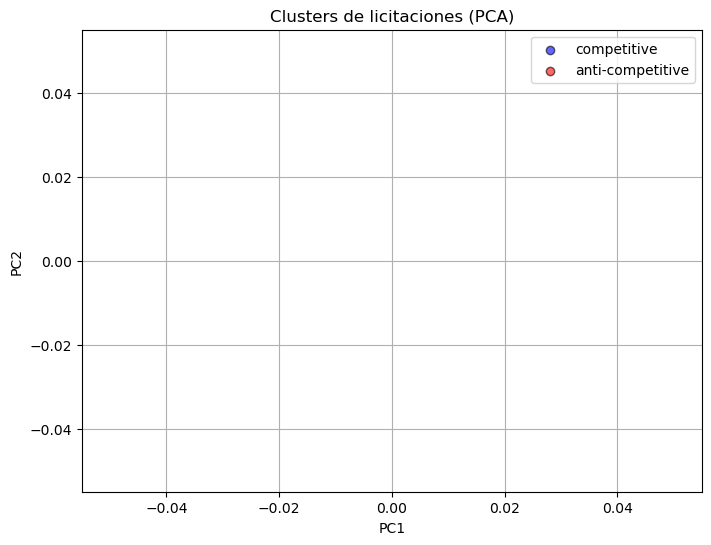

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame para graficar
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['cluster'] = summary_df['cluster']

# Graficar
plt.figure(figsize=(8,6))
for label, color in zip(['competitive', 'anti-competitive'], ['blue', 'red']):
    subset = plot_df[plot_df['cluster'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, label=label, alpha=0.6, edgecolors='k')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters de licitaciones (PCA)')
plt.legend()
plt.grid(True)
plt.show()


In [90]:
# Asegurar parseo de la fecha (mantiene offset)
df['date'] = pd.to_datetime(df['date'], utc=True)

# Ordenar por ocid y fecha (si hay empates de tiempo, mantiene orden original estable)
df = df.sort_values(['ocid', 'date'], kind='stable').reset_index(drop=True)

# Recalcular índice de orden secuencial por ocid
df['order'] = df.groupby('ocid').cumcount() + 1

# Métricas de convergencia (pasos)
df['min_acum'] = df.groupby('ocid')['amount'].cummin()
final_min = df.groupby('ocid')['amount'].transform('min')
df['dist_rel_min_final'] = (df['amount'] - final_min) / final_min
df['dist_rel_min_acum'] = (df['amount'] - df['min_acum']) / df['min_acum']
df['delta_consec'] = df.groupby('ocid')['amount'].diff()
df['delta_consec_pct'] = df.groupby('ocid')['amount'].pct_change()

# Métricas temporales
first_time = df.groupby('ocid')['date'].transform('min')
last_time  = df.groupby('ocid')['date'].transform('max')
df['elapsed_sec'] = (df['date'] - first_time).dt.total_seconds()
total_duration = (last_time - first_time).dt.total_seconds().replace(0, np.nan)
df['elapsed_ratio'] = df['elapsed_sec'] / total_duration  # 0→inicio, 1→fin (NaN si solo una puja)

# Paso y tiempo hasta alcanzar el mínimo final por ocid
first_min_row = df[df['amount'] == final_min].groupby('ocid').agg(
    steps_to_reach_final_min=('order', 'min'),
    time_to_reach_final_min=('elapsed_sec', 'min')
)
summary = first_min_row.join(
    df.groupby('ocid')['order'].max().rename('total_bids')
).join(
    (df.groupby('ocid')['elapsed_sec'].max()).rename('total_duration_sec')
)
summary['ratio_steps'] = summary['steps_to_reach_final_min'] / summary['total_bids']
summary['ratio_time'] = summary['time_to_reach_final_min'] / summary['total_duration_sec']
summary.head()

C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\1740220062.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['order'] = df.groupby('ocid').cumcount() + 1
C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\1740220062.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['min_acum'] = df.groupby('ocid')['amount'].cummin()
C:\Users\AndrésL\AppData\Local\Temp\ipykernel_12840\1740220062.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default an

,steps_to_reach_final_min,time_to_reach_final_min,total_bids,total_duration_sec,ratio_steps,ratio_time
ocid,,,,,,
ocds-5wno2w--SIE-ETAPACV-14-2015-312203,2,177632.0,2,177632.0,1.000000,1.0
ocds-5wno2w-.SIE-ARCSA-008-2015-488199,5,59557.0,5,59557.0,1.000000,1.0
ocds-5wno2w-.SIE-HCAM-222-2015-54651,2,138041.0,2,138041.0,1.000000,1.0
ocds-5wno2w-002-CGDS-SIE-2015-591897,12,347798.0,13,347798.0,0.923077,1.0
ocds-5wno2w-006-CGDS-SIE-2015-591897,2,172189.0,2,172189.0,1.000000,1.0


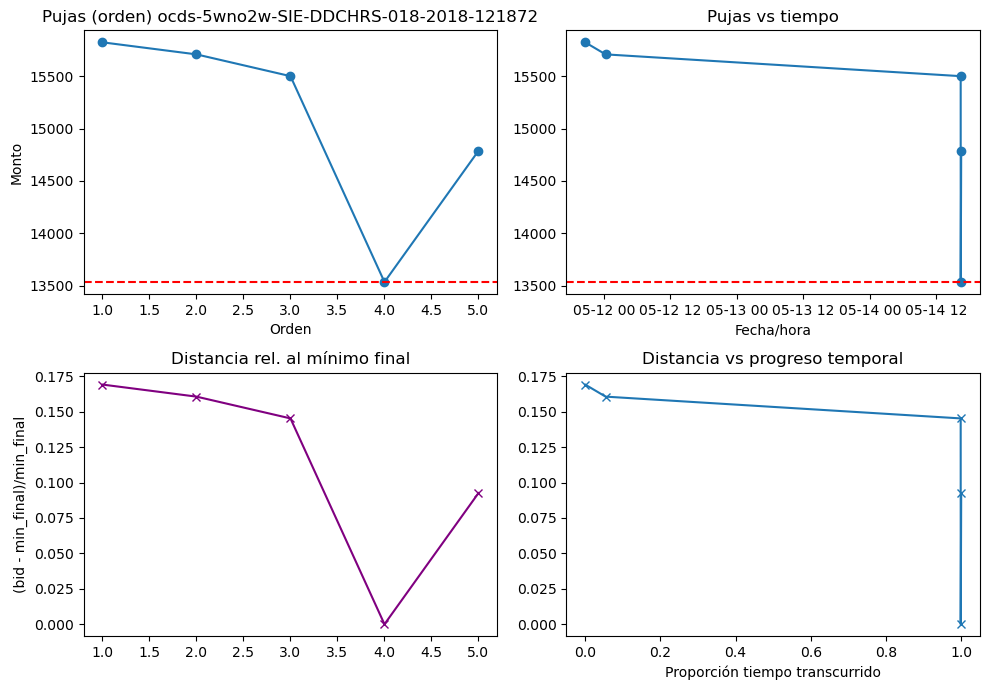

In [114]:
import matplotlib.pyplot as plt

def plot_convergence(ocid):
    s = df[df['ocid'] == ocid].sort_values('date')
    fig, axes = plt.subplots(2, 2, figsize=(10,7))
    
    # Trayectoria vs orden
    axes[0,0].plot(s['order'], s['amount'], marker='o')
    axes[0,0].axhline(s['amount'].min(), ls='--', color='red')
    axes[0,0].set_title(f'Pujas (orden) {ocid}')
    axes[0,0].set_xlabel('Orden'); axes[0,0].set_ylabel('Monto')
    
    # Trayectoria vs tiempo
    axes[0,1].plot(s['date'], s['amount'], marker='o')
    axes[0,1].axhline(s['amount'].min(), ls='--', color='red')
    axes[0,1].set_title('Pujas vs tiempo')
    axes[0,1].set_xlabel('Fecha/hora')
    
    # Distancia relativa al mínimo final (orden)
    axes[1,0].plot(s['order'], s['dist_rel_min_final'], marker='x', color='purple')
    axes[1,0].set_title('Distancia rel. al mínimo final')
    axes[1,0].set_ylabel('(bid - min_final)/min_final')
    
    # Distancia vs tiempo (ratio)
    axes[1,1].plot(s['elapsed_ratio'], s['dist_rel_min_final'], marker='x')
    axes[1,1].set_title('Distancia vs progreso temporal')
    axes[1,1].set_xlabel('Proporción tiempo transcurrido')
    
    plt.tight_layout()
    plt.show()

example_ocid = "ocds-5wno2w-SIE-DDCHRS-018-2018-121872"
plot_convergence(example_ocid)

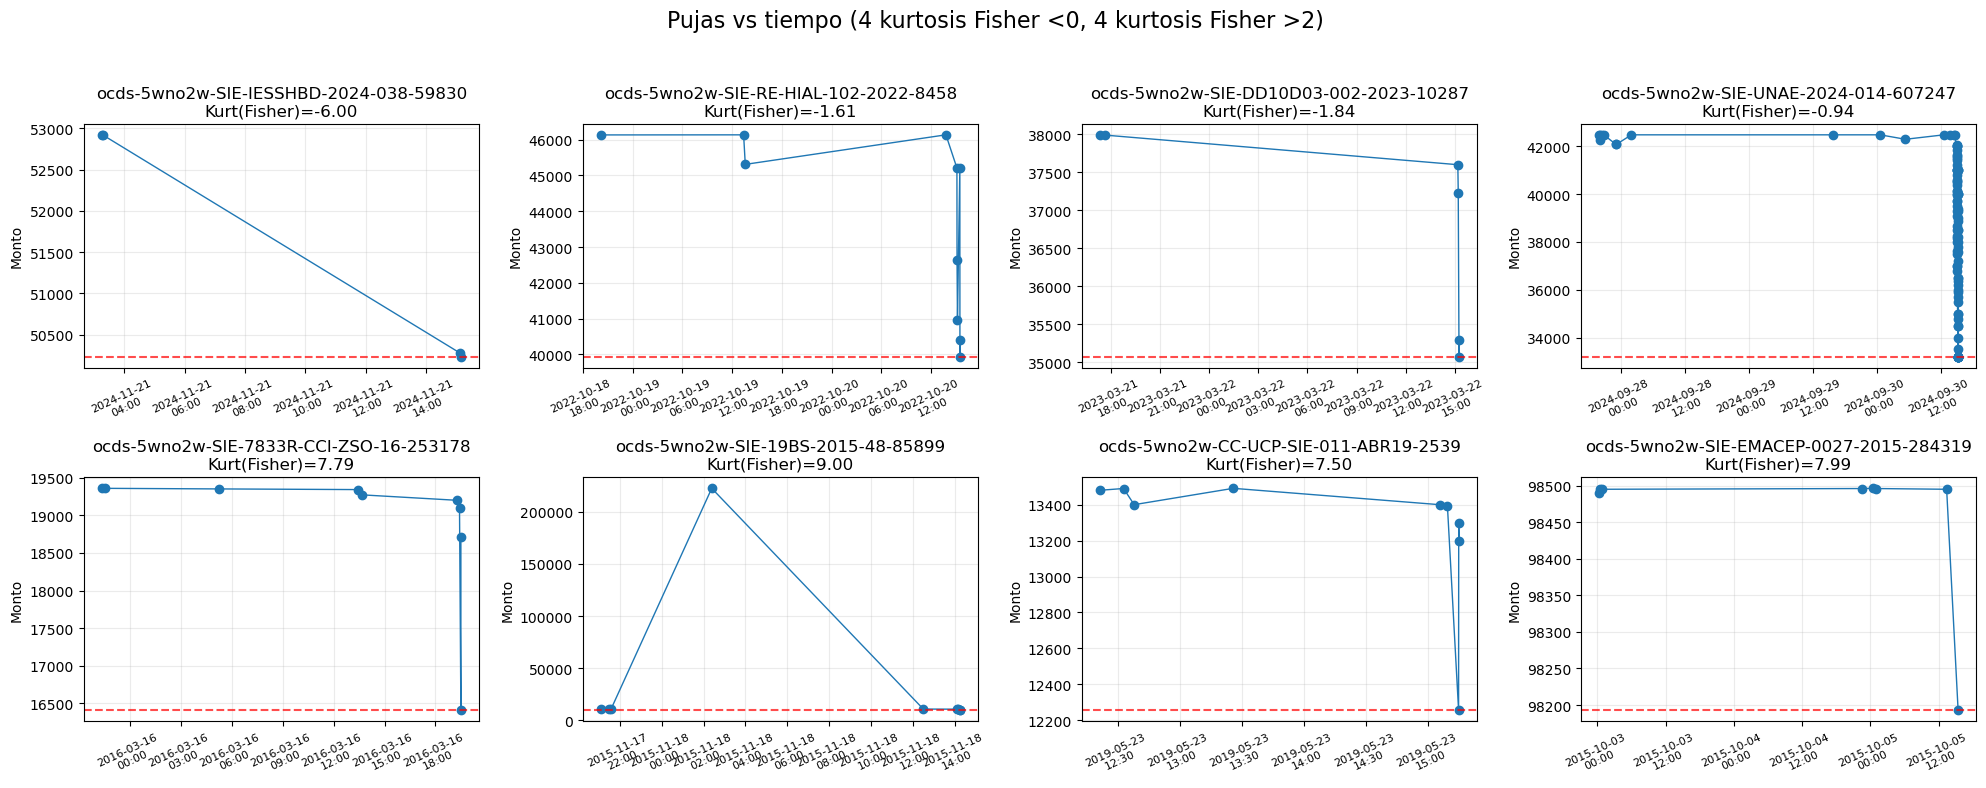

OCID seleccionados (kurtosis Fisher):


,ocid,kurtosis
0,ocds-5wno2w-SIE-IESSHBD-2024-038-59830,-5.996482
1,ocds-5wno2w-SIE-RE-HIAL-102-2022-8458,-1.612572
2,ocds-5wno2w-SIE-DD10D03-002-2023-10287,-1.843710
3,ocds-5wno2w-SIE-UNAE-2024-014-607247,-0.942881
4,ocds-5wno2w-SIE-7833R-CCI-ZSO-16-253178,7.787768
5,ocds-5wno2w-SIE-19BS-2015-48-85899,8.999229
6,ocds-5wno2w-CC-UCP-SIE-011-ABR19-2539,7.504128
7,ocds-5wno2w-SIE-EMACEP-0027-2015-284319,7.991051


In [150]:
# Matriz 2x4 aleatoria usando SOLO kurtosis de Fisher (exceso). 
# Equivalencias previas: Pearson<3  -> Fisher<0 ; Pearson>5 -> Fisher>2

from scipy.stats import kurtosis as _kur
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegurar columna 'kurtosis' (Fisher/exceso) (ya la produce tu primer bloque)
if 'kurtosis' not in results_df.columns:
    k_ser = (df.groupby('ocid')['amount']
               .apply(lambda x: _kur(x, fisher=True, bias=False) if len(x) >= 4 else np.nan))
    results_df = k_ser.reset_index(name='kurtosis')

# Umbrales en términos de exceso (Fisher)
low_thr  = 0.0   # <0 leptocurtosis negativa (más plana que normal)
high_thr = 7.0   # >2 muy apuntada respecto a normal

low_pool  = results_df[results_df['kurtosis'] < low_thr].dropna(subset=['kurtosis'])
high_pool = results_df[results_df['kurtosis'] > high_thr].dropna(subset=['kurtosis'])

need_low, need_high = 4, 4
if len(low_pool) < need_low or len(high_pool) < need_high:
    print(f"Insuficientes OCID (low:{len(low_pool)} / high:{len(high_pool)}). Ajusta umbrales.")
else:
    # Muestras aleatorias (sin random_state para que cambie cada ejecución)
    low_sel  = low_pool.sample(need_low, replace=False)
    high_sel = high_pool.sample(need_high, replace=False)
    sel = pd.concat([low_sel, high_sel], ignore_index=True)

    fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharey=False)
    axes = axes.ravel()

    for ax, (_, row) in zip(axes, sel.iterrows()):
        ocid = row['ocid']
        kf   = row['kurtosis']  # Fisher (exceso)
        s = df[df['ocid'] == ocid].sort_values('date')
        if s.empty:
            ax.set_title(f"{ocid}\n(sin datos)")
            ax.axis('off')
            continue
        ax.plot(s['date'], s['amount'], marker='o', lw=1)
        ax.axhline(s['amount'].min(), ls='--', color='red', alpha=0.7)
        ax.set_title(f"{ocid}\nKurt(Fisher)={kf:0.2f}")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
        ax.tick_params(axis='x', rotation=25, labelsize=8)
        ax.set_ylabel('Monto')
        ax.grid(alpha=0.25)

    fig.suptitle('Pujas vs tiempo (4 kurtosis Fisher <0, 4 kurtosis Fisher >2)', fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    print("OCID seleccionados (kurtosis Fisher):")
    display(sel[['ocid','kurtosis']])

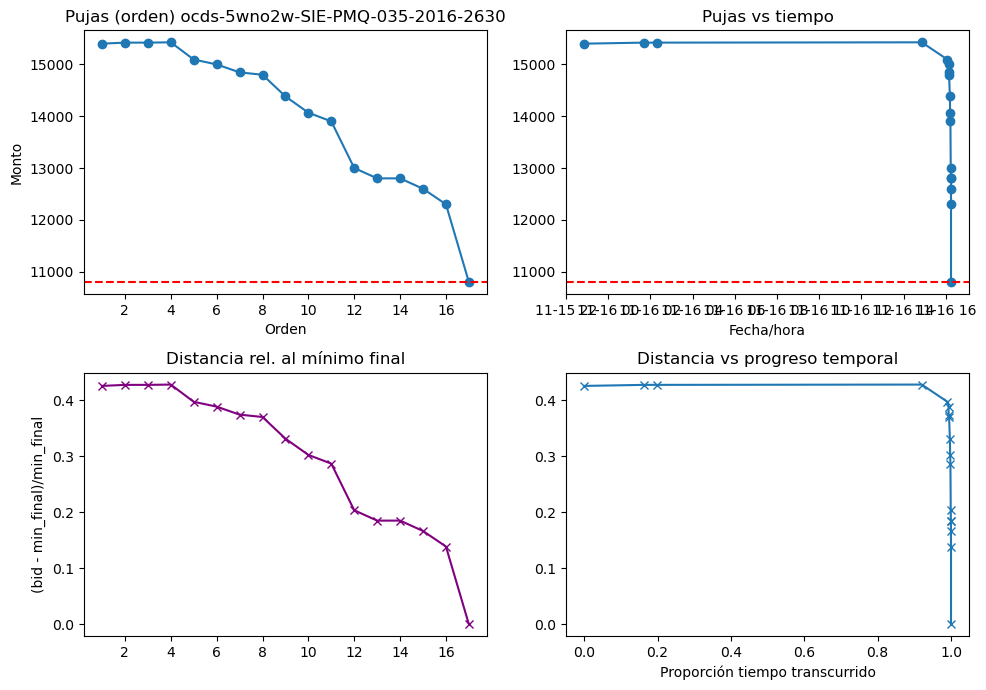

In [ ]:
import matplotlib.pyplot as plt

def plot_convergence(ocid):
    s = df[df['ocid'] == ocid].sort_values('date')
    fig, axes = plt.subplots(2, 2, figsize=(10,7))
    
    # Trayectoria vs orden
    axes[0,0].plot(s['order'], s['amount'], marker='o')
    axes[0,0].axhline(s['amount'].min(), ls='--', color='red')
    axes[0,0].set_title(f'Pujas (orden) {ocid}')
    axes[0,0].set_xlabel('Orden'); axes[0,0].set_ylabel('Monto')
    
    # Trayectoria vs tiempo
    axes[0,1].plot(s['date'], s['amount'], marker='o')
    axes[0,1].axhline(s['amount'].min(), ls='--', color='red')
    axes[0,1].set_title('Pujas vs tiempo')
    axes[0,1].set_xlabel('Fecha/hora')
    
    # Distancia relativa al mínimo final (orden)
    axes[1,0].plot(s['order'], s['dist_rel_min_final'], marker='x', color='purple')
    axes[1,0].set_title('Distancia rel. al mínimo final')
    axes[1,0].set_ylabel('(bid - min_final)/min_final')
    
    # Distancia vs tiempo (ratio)
    axes[1,1].plot(s['elapsed_ratio'], s['dist_rel_min_final'], marker='x')
    axes[1,1].set_title('Distancia vs progreso temporal')
    axes[1,1].set_xlabel('Proporción tiempo transcurrido')
    
    plt.tight_layout()
    plt.show()

example_ocid = "ocds-5wno2w-SIE-PMQ-035-2016-2630"
plot_convergence(example_ocid)